In [1]:
# https://www.kuniga.me/blog/2021/05/13/lpc-in-python.html

# imports
# import sounddevice as sd # !pip install sounddevice

import scipy.io.wavfile
import numpy as np
from scipy.signal import resample, spectrogram, correlate
import matplotlib.pyplot as plt

plt.style.use("seaborn")

In [2]:
# Variables
fs = 8000  # Sample rate
filename = 'aa.wav'
window_size = 20

In [3]:
# Lectura del archivo
# For this post we’ll assume our audio has a single channel so that pcm_data is simply an array containing the amplitude of each samples
sample_rate, pcm_data = scipy.io.wavfile.read(filename)

# Se pasa las amplitudes a numpy
amplitudes = np.array(pcm_data)

# normalize
amplitudes_norm = 0.9*amplitudes/max(abs(amplitudes)); 

amplitudes_norm.shape, sample_rate

((32000,), 8000)

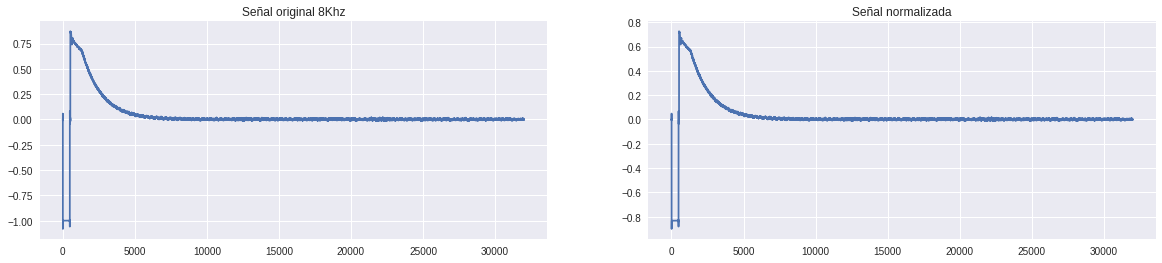

In [4]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.plot(amplitudes)
plt.title("Señal original 8Khz")

plt.subplot(1, 2, 2)
plt.plot(amplitudes_norm)
plt.title("Señal normalizada");

In [5]:
def create_overlapping_blocks(x, w, R = 0.5):
    n = len(x)
    nw = len(w)
    step = floor(nw * (1 - R))
    nb = floor((n - nw) / step) + 1

    B = np.zeros((nb, nw))

    for i in range(nb):
        offset = i * step
        B[i, :] = w * x[offset : nw + offset]

    return B

In [6]:
def spectral_statistics(y: np.ndarray, fs: int) -> float:
    """
    Compute mean frequency

    :param y: 1-d signal
    :param fs: sampling frequency [Hz]
    :return: mean frequency
    """
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(y.shape[0], d=1/fs)    
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    return mean 

In [7]:
amp_trunc = amplitudes[8000:]

In [8]:
np.array([
    spectral_statistics(amp_trunc[i: int(i + fs * window_size / 1000)], fs)
    for i in range(0, amp_trunc.shape[0], window_size)
]).mean()

899.3996312586991

In [9]:
spectral_statistics(amp_trunc, fs)

1064.7080838476081

In [10]:
def parabolic(f, x):
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    """
    corr = correlate(sig, sig, mode='full')
    corr = corr[len(corr)//2:]
    d = np.diff(corr)
    start = np.nonzero(d > 0)[0][0]
    peak = np.argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return fs / px

In [11]:
freq_from_autocorr(amp_trunc, fs)

187.18496523827432

In [12]:
np.array([
    freq_from_autocorr(amp_trunc[i: int(i + fs * window_size / 1000)], fs)
    for i in range(0, amp_trunc.shape[0], window_size)
]).mean()

355.958751939769

/tmp/ipykernel_8575/3176027758.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(t, f, np.log10(Sxx))


Text(0.5, 0, 'Time [sec]')

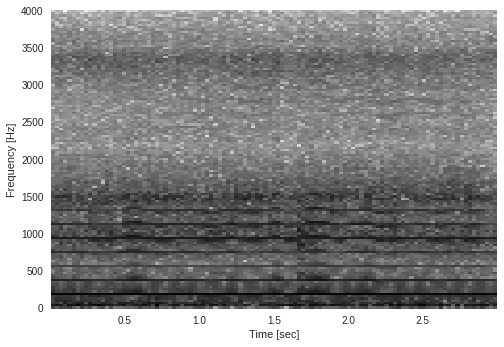

In [13]:
f,t,Sxx = spectrogram(amp_trunc, fs)
plt.pcolormesh(t, f, np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')